In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
!pip install pystan~=2.14
!pip install fbprophet

In [ ]:
df=pd.read_csv("/content/updated_restaurant_footfall.csv")
df.head()

df["ds"] = pd.to_datetime(df["ds"])
print(df.dtypes)
print("#################################################")
df.describe

Unnamed: 0              object
Unnamed: 0.1             int64
ds              datetime64[ns]
y                        int64
dtype: object
#################################################


<bound method NDFrame.describe of                          Unnamed: 0  Unnamed: 0.1         ds    y
0     1970-01-01 00:00:00.000000750           750 2009-08-08  460
1     1970-01-01 00:00:00.000000751           751 2009-08-09  187
2     1970-01-01 00:00:00.000000752           752 2009-08-10  205
3     1970-01-01 00:00:00.000000753           753 2009-08-11  311
4     1970-01-01 00:00:00.000000754           754 2009-08-12  287
...                             ...           ...        ...  ...
2912  1970-01-01 00:00:00.000003662          3662 2017-08-13  326
2913  1970-01-01 00:00:00.000003663          3663 2017-08-14  349
2914  1970-01-01 00:00:00.000003664          3664 2017-08-15  402
2915  1970-01-01 00:00:00.000003665          3665 2017-08-16  393
2916  1970-01-01 00:00:00.000003666          3666 2017-08-17  406

[2917 rows x 4 columns]>

In [ ]:
df.index = pd.to_datetime(df.index)

print(len(df))

2917


In [ ]:
df = df.iloc[750:]
df = df.iloc[:-500]


In [ ]:
df.to_csv('C:\\Users\\Admin\\OneDrive\\Desktop\\Smollan\\updated_restaurant_footfall.csv')


In [ ]:
import fbprophet


In [ ]:
print(len(df))

2917


In [ ]:
from fbprophet import Prophet 
prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
prophet_model.fit(df)

In [ ]:
future_dataset= prophet_model.make_future_dataframe(periods=200) 
future_dataset.tail()

,ds
3112,2018-03-01
3113,2018-03-02
3114,2018-03-03
3115,2018-03-04
3116,2018-03-05


In [ ]:
pred = prophet_model.predict(future_dataset)
pred[['ds','yhat', 'yhat_lower', 'yhat_upper']].head() # only useful columns

,ds,yhat,yhat_lower,yhat_upper
0,2009-08-08,450.596535,356.184091,540.392059
1,2009-08-09,215.182145,132.068550,297.575711
2,2009-08-10,220.997799,135.200619,303.335836
3,2009-08-11,230.953722,136.227692,323.763788
4,2009-08-12,243.154620,152.971775,339.704276


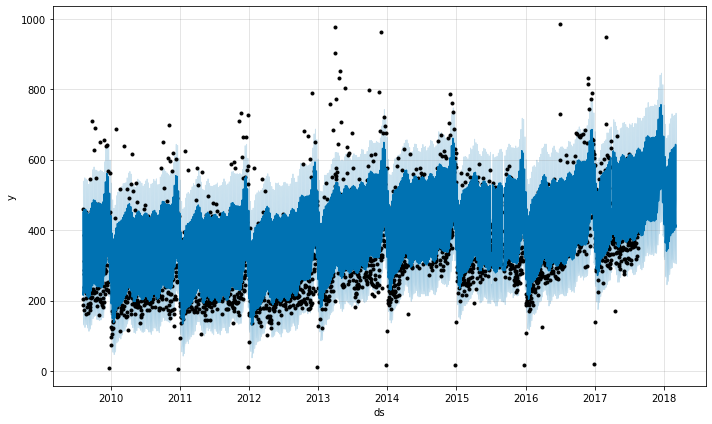

In [ ]:
prophet_model.plot(pred);

In [ ]:
def fb_prophet_function(data, future_years, seasonality_name, seasonality_val,seasonality_fourier, **params):
    """
    Trains a fb prophet model on given hyperparameters and custom
    seasonality, predicts on future dataset, plot the results and
    return the model.
    """
    start= time.time()
    prophet_model = Prophet(**params)
    
    prophet_model.add_seasonality(name=seasonality_name, period=seasonality_val, fourier_order=seasonality_fourier)
        
    prophet_model.fit(data)
    
    future_dataset = prophet_model.make_future_dataframe(periods=future_years, freq='y')
    
    pred = prophet_model.predict(future_dataset)
    
    prophet_model.plot(pred, figsize=(15,7));
    plt.ylim(-500, 3000)
    plt.title(f"fourier order{seasonality_fourier}, seasonality time {seasonality_name}")
    plt.show()
    
    end = time.time()
    print(f"Total Execution Time {end-start} seconds")
    return prophet_model

In [ ]:
def plot_valid(validation_set, size, model):
    pred = model.predict(validation_set)
    temp = df[-size:].copy().reset_index()
    temp['pred']=pred['yhat']
    temp.set_index('ds')[['y', 'pred']].plot()
    plt.tight_layout();

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


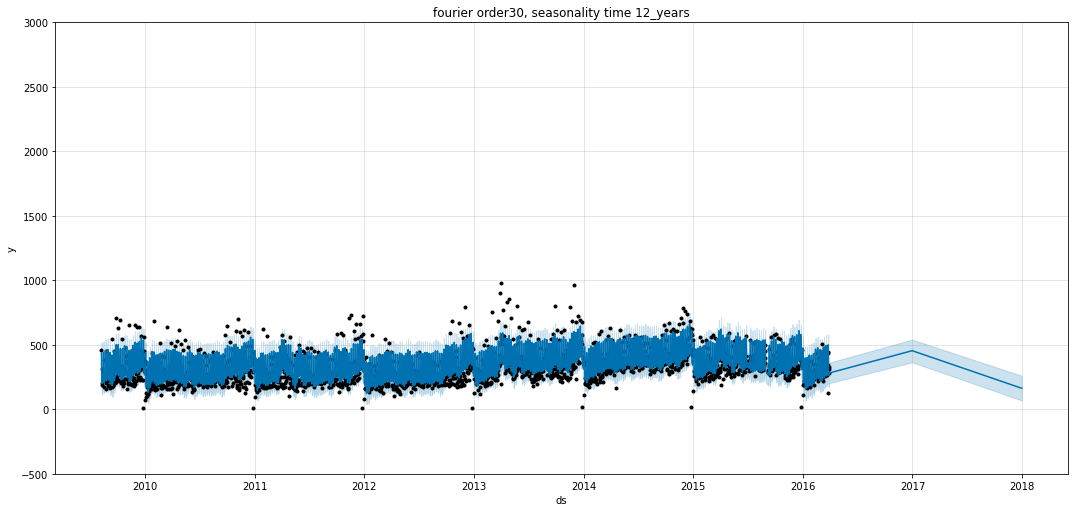

Total Execution Time 8.561412811279297 seconds


In [ ]:
training_set = df[:-500] 
validation_set = df[-500:] 
fifteen_years = fb_prophet_function(data=training_set, future_years=2, seasonality_name='12_years', seasonality_val=365*2, seasonality_fourier=30,seasonality_mode='additive')

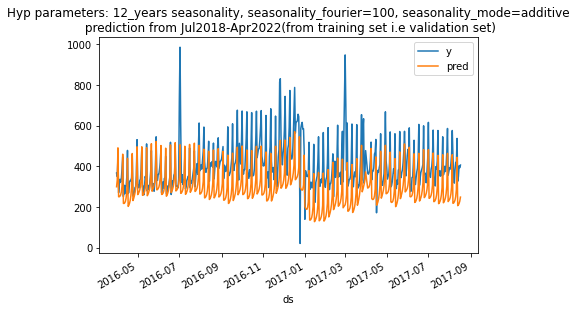

In [ ]:
plot_valid(validation_set, 500, fifteen_years)
plt.title("Hyp parameters:  seasonality, seasonality_fourier=100, seasonality_mode=additive\n prediction from Jul2018-Apr2022(from training set i.e validation set)");

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


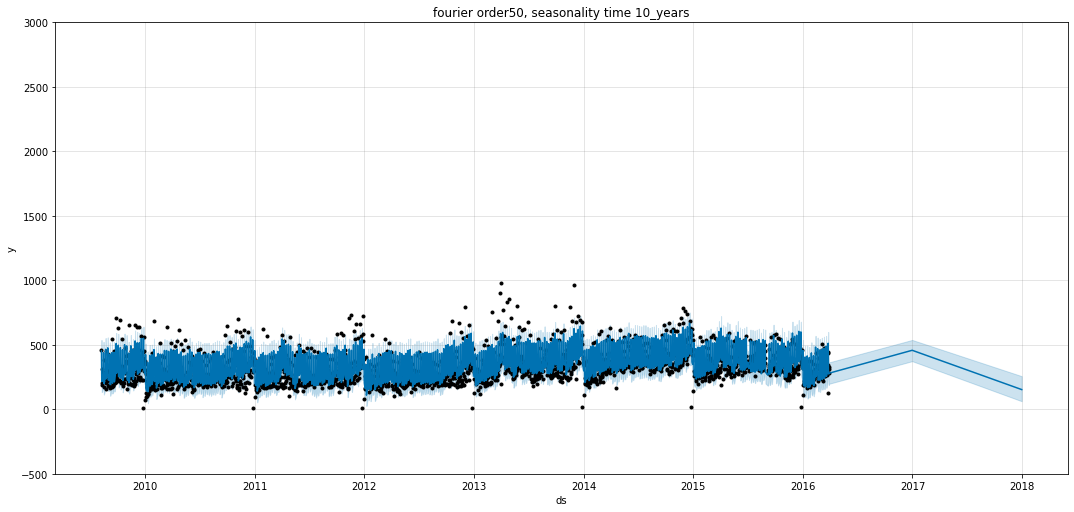

Total Execution Time 8.870112657546997 seconds


In [ ]:
# 3 years seasonlaity, no other seasonlaity, additive, less fourier
training_set = df[:-500]
validation_set = df[-500:]
ten_years_model = fb_prophet_function(data=training_set, future_years=2, seasonality_name='10_years', seasonality_val=365*2, seasonality_fourier=50,seasonality_mode='additive')

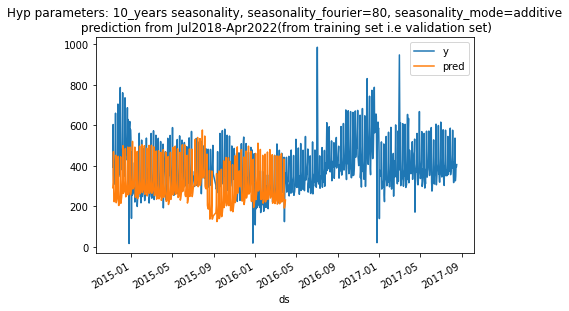

In [ ]:
plot_valid(validation_set, 1000, ten_years_model)
plt.title("Hyp parameters: seasonality, seasonality_fourier=80, seasonality_mode=additive\n prediction from Jul2018-Apr2022(from training set i.e validation set)");

In [ ]:
import pickle
with open('/content/sample_data/fbNew.pckl', 'wb') as fout: # saving the model in models directory
    pickle.dump(ten_years_model, fout)